In [311]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_california_housing
import torch
import model as md
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import tqdm
import torch_intermediate_layer_getter as ilg
from model import MLP

In [312]:
california_housing = fetch_california_housing(as_frame=True)
X = california_housing.data.loc[:, ['HouseAge', 'AveRooms', 'AveBedrms', 'Population',
                                     'AveOccup', 'Latitude', 'Longitude']]
Y = pd.concat([california_housing.target, california_housing.data.loc[:, 'MedInc']], axis = 1)
# X = california_housing.data.loc[:, ['HouseAge', 'AveRooms', 'AveBedrms', 'Population',
#                                      'AveOccup', 'Latitude', 'Longitude', 'MedInc']]
# Y = california_housing.target

In [313]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.6, random_state=42)
X_calib, X_test, Y_calib, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
Y_train = torch.tensor(Y_train.values, dtype=torch.float32)
Y_test = torch.tensor(Y_test.values, dtype=torch.float32)
X_calib = torch.tensor(X_calib.values, dtype=torch.float32)
Y_calib = torch.tensor(Y_calib.values, dtype=torch.float32)

In [314]:
torch.manual_seed(42)
train_loader = DataLoader(list(zip(X_train, Y_train)), batch_size=64, shuffle=True)
calib_loader = DataLoader(list(zip(X_calib, Y_calib)), batch_size=1, shuffle=True)
test_loader = DataLoader(list(zip(X_test, Y_test)), batch_size=1, shuffle=True)

In [315]:
lol = md.MLP([7, 64, 128, 64, 2])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lol = lol.to(device)
lr = 0.01
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, lol.parameters()), lr=lr, weight_decay = 0.0001)

In [316]:
def loss_fn_mse(y, y_hat):
    mse_loss = torch.nn.MSELoss()
    return mse_loss(y, y_hat)

In [317]:
def loss_fn_VAE(recon_feature, og_feature, means, log_var):
    mse_loss = torch.nn.MSELoss()
    mse = mse_loss(recon_feature, og_feature)
    kl_loss = -0.5 * torch.sum(1 + log_var - means.pow(2) - log_var.exp())
    return mse + kl_loss, mse, kl_loss

In [318]:
def train_MLP(model, train_loader, epochs, optimizer, loss_fn):
    model.train()
    for epoch in range(epochs):
        with tqdm.tqdm(train_loader, unit="batch") as tepoch:
            for x, y in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                x = x.to(device)
                y = y.to(device)
                optimizer.zero_grad()
                y_hat = model(x)
                loss = loss_fn(y, y_hat)
                loss.backward()
                optimizer.step()
                tepoch.set_postfix(loss=loss.item())
        
        # print('Epoch: {}, Loss: {}'.format(epoch, loss.item()))
  

In [319]:
train_MLP(lol, train_loader, 100, optimizer, loss_fn_mse)

Epoch 99: 100%|██████████| 129/129 [00:00<00:00, 341.55batch/s, loss=0.879]


In [320]:
print(loss_fn_mse(lol(X_test.to(device)), Y_test.to(device)))

tensor(0.7828, grad_fn=<MseLossBackward0>)


In [323]:
# activation = {}
# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output.detach()
#     return hook
# # print(lol.mlp[5])
# lol.mlp[4].register_forward_hook(get_activation('ReLU Layer 3'))
# #lol..register_forward_hook(get_activation('ReLU Layer 1'))
# # lol.fc3.register_forward_hook(get_activation('fc3'))
# output = lol(X_test.to(device))
# activation['ReLU Layer 3'].shape

lol.eval()

MLP(
  (mlp): Sequential(
    (Linear Layer 0): Linear(in_features=7, out_features=64, bias=True)
    (BatchNorm Layer 0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ReLU Layer 0): ReLU()
    (Linear Layer 1): Linear(in_features=64, out_features=128, bias=True)
    (BatchNorm Layer 1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ReLU Layer 1): ReLU()
    (Linear Layer 2): Linear(in_features=128, out_features=64, bias=True)
    (BatchNorm Layer 2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ReLU Layer 2): ReLU()
    (Linear Layer 3): Linear(in_features=64, out_features=2, bias=True)
  )
)

Pulling the outputs from the penultimate layer with training data

In [324]:
return_layers = {
    'ReLU Layer 2': 'relu1'
}
mid_getter = ilg.IntermediateLayerGetter(lol.mlp, return_layers=return_layers)
mid_output, model_output = mid_getter(X_train.to(device))
# mid_output['relu1'].shape
W_train = mid_output['relu1']
mid_output, model_output = mid_getter(X_test.to(device))
W_test = mid_output['relu1']
train_gen_loader = DataLoader(list(zip(W_train, X_train)), batch_size=64, shuffle=True)
test_gen_loader = DataLoader(list(zip(W_test, X_test)), batch_size=1, shuffle=True)
train_gen_loader = DataLoader(list(zip(W_train, X_train)), batch_size=64, shuffle=True)
test_gen_loader = DataLoader(list(zip(W_test, X_test)), batch_size=1, shuffle=True)

In [325]:
print(lol.mlp[-1](W_train[0].unsqueeze(0)))
print(model_output[0].unsqueeze(0))
print(lol.mlp(X_train[0].unsqueeze(0)))
print(lol.mlp[-1](lol.mlp[:-1](X_train[0].unsqueeze(0))))
print(lol(X_train[0].unsqueeze(0)))

tensor([[0.6530, 1.8045]], grad_fn=<AddmmBackward0>)
tensor([[1.6743, 2.2921]], grad_fn=<UnsqueezeBackward0>)
tensor([[0.6530, 1.8045]], grad_fn=<AddmmBackward0>)
tensor([[0.6530, 1.8045]], grad_fn=<AddmmBackward0>)
tensor([[0.6530, 1.8045]], grad_fn=<AddmmBackward0>)


In [326]:
cvae = md.CVAE(64, [32, 32], 8, [32, 32], 7)
cvae = cvae.to(device)
lr = 0.01
optimizer_2 = torch.optim.Adam(filter(lambda p: p.requires_grad, cvae.parameters()), lr=lr, weight_decay = 0.0001)

In [327]:
def train_CVAE(model, train_loader, epochs, optimizer, loss_fn):
    model.train()
    for epoch in range(epochs):
        with tqdm.tqdm(train_loader, unit="batch") as tepoch:
            for w, x in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                w = w.to(device)
                x = x.to(device)
                optimizer.zero_grad()
                w_hat, mean, log_var = model(w, x)
                loss, recon_loss, kl_loss = loss_fn(w_hat, w, mean, log_var)
                loss.backward(retain_graph=True)
                optimizer.step()
                tepoch.set_postfix(loss=loss.item(), recon_loss=recon_loss.item(), kl_loss=kl_loss.item())
        
  

In [328]:
train_CVAE(cvae, train_gen_loader, 20, optimizer_2, loss_fn_VAE)

Epoch 19: 100%|██████████| 129/129 [00:02<00:00, 50.41batch/s, kl_loss=0.000152, loss=0.00827, recon_loss=0.00811]


In [329]:
def get_score_quantile(alpha, model, calib_loader):
    model.eval()
    with torch.no_grad():
        i = 0
        losses = []
        for data, target in calib_loader:
            data = data.to(device)
            target = target.to(device)
            i = i + 1
            Y_hat = model(data)
            loss = loss_fn_mse(Y_hat, target).cpu().numpy()
            losses.append(loss)
    N_c = len(calib_loader)
    return np.quantile(losses, (N_c + 1)*(1 - alpha)/N_c), np.sort(losses)

In [402]:
def get_variance_estimate(gen_model, model, calib_loader):
    gen_model.eval()
    with torch.no_grad():
        i = 0
        losses = np.zeros(64)
        for data, target in calib_loader:
            data = data.to(device)
            target = target.to(device)
            i = i + 1
            Z_hat = gen_model.generate(data, 1)
            Z = model.mlp[:-1](data)
            mse_loss = torch.nn.MSELoss(reduction='none')
            loss = torch.square(Z_hat - Z)
            losses = np.vstack((losses, loss.cpu().numpy()))
    return torch.tensor(np.sqrt(np.mean(losses[1:], axis = 0)), dtype = torch.float32)
    

In [387]:
score_quantile, loss = get_score_quantile(0.1, lol, calib_loader)
print(score_quantile)
print(loss)
print(torch.max(Y_train, dim = 0))

9.025642655062121
[3.4321527e-04 4.0387094e-04 4.8093742e-04 ... 7.0469193e+01 8.0595589e+01
 1.1075569e+02]
torch.return_types.max(
values=tensor([ 5.0000, 15.0001]),
indices=tensor([ 17, 167]))


In [403]:
variance_est = get_variance_estimate(cvae, lol, calib_loader)
print(variance_est)

tensor([1.6489e-03, 3.9402e-04, 2.9341e-02, 1.1422e-02, 1.2737e-03, 1.1283e-02,
        9.8341e-02, 4.9391e-03, 1.0756e+00, 5.8151e-01, 4.8306e-02, 8.2589e-02,
        4.3628e-02, 8.6326e-02, 1.0444e-02, 5.1097e-01, 1.2151e-02, 4.3765e-01,
        2.4210e-01, 3.1540e-03, 2.7683e-01, 4.4242e-01, 1.5889e-01, 3.9922e-03,
        3.5978e-02, 1.7744e-02, 5.3643e-02, 4.9716e-02, 2.7084e-02, 9.0113e-03,
        6.4326e-03, 1.0229e+00, 2.6572e-02, 7.1532e-02, 8.3549e-03, 1.8787e-01,
        8.5447e-02, 6.3412e-03, 1.7357e-02, 8.0958e-03, 8.8381e-03, 9.4307e-02,
        3.1508e-01, 1.4519e-02, 3.7637e-02, 1.7171e+00, 3.6249e-03, 5.6761e-02,
        6.0403e-01, 4.9218e-02, 8.8928e-02, 4.2897e-02, 1.2249e-03, 6.7871e-01,
        2.3588e-01, 2.2266e+00, 9.5863e-03, 5.1844e-02, 1.8970e-02, 6.1418e-03,
        6.0145e-02, 2.4453e-02, 1.1283e-03, 7.7235e-03])


In [433]:
def pp_csi(quantile, gen_model, point_estimator, n_samples, data, layer, var_est):
    gen_model.eval()
    point_estimator.eval()
    y_hat = point_estimator(data.reshape(1, -1))
    regen_w = gen_model.generate(data.reshape(1, -1), n_samples)
    noise = torch.randn(n_samples, regen_w.shape[1])
    regen_z = regen_w + noise * var_est.repeat(n_samples, 1)
    regen_y = layer(regen_z)
    # regen_y = point_estimator(regen_w)
    prediction_set = y_hat.detach().numpy().reshape(1, -1)
    for i in range(n_samples):
        if loss_fn_mse(regen_y[i], y_hat) <= quantile:
            prediction_set = np.vstack((prediction_set, regen_y[i].detach().numpy().reshape(1, -1)))
    return prediction_set


In [434]:
# print(X_test[0].reshape(1, 7))
predictionset= pp_csi(score_quantile, cvae, lol, 200, X_test[0], lol.mlp[-1], variance_est)
# print(Y_train[0])
# print(predictionset)
# print(regen_w[0])
# print(lol.mlp[:-1](X_train[0].unsqueeze(0)))
# print(loss_fn_mse(regen_w[0], lol.mlp[:-1](X_train[0].unsqueeze(0))))
# print(loss_fn_mse(lol(X_train[0].unsqueeze(0)), lol.mlp[-1](regen_w[0])))
print(len(predictionset))

200


/Users/srayan/Documents/CPAF2/Experiments_PPCSI/CaliforniaHousing/.venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Wow um this is trash and this is proof that something is sus

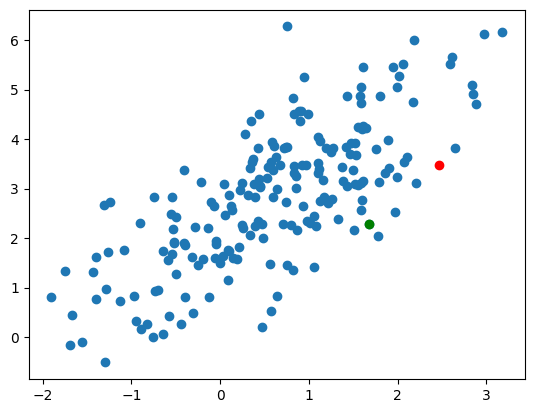

In [435]:
plot_x = predictionset[:, 0]
# plot_x = regen_y
plot_y = predictionset[:, 1]
plt.scatter(plot_x, plot_y)
plt.scatter(Y_test[0, 0].detach().numpy(), Y_test[0, 1].detach().numpy(), color = 'red')
plt.scatter(predictionset[0, 0], predictionset[0, 1], color = 'green')


In [437]:
def make_10_scatterplots(data, score_quantile, gen_model, point_estimator, layer, variance_est, n_samples, true_y):
    fig, ax = plt.subplots(2, 5, figsize=(20, 8))
    for i in range(10):
        pred_set = pp_csi(score_quantile, gen_model, point_estimator, n_samples, data[i], layer, variance_est)
        plot_x = pred_set[:, 0]
        plot_y = pred_set[:, 1]
        ax[i//5, i%5].scatter(plot_x, plot_y)
        ax[i//5, i%5].scatter(true_y[i, 0].detach().numpy(), true_y[i, 1].detach().numpy(), color = 'red')
        ax[i//5, i%5].scatter(pred_set[0, 0], pred_set[0, 1], color = 'green')
    plt.show()


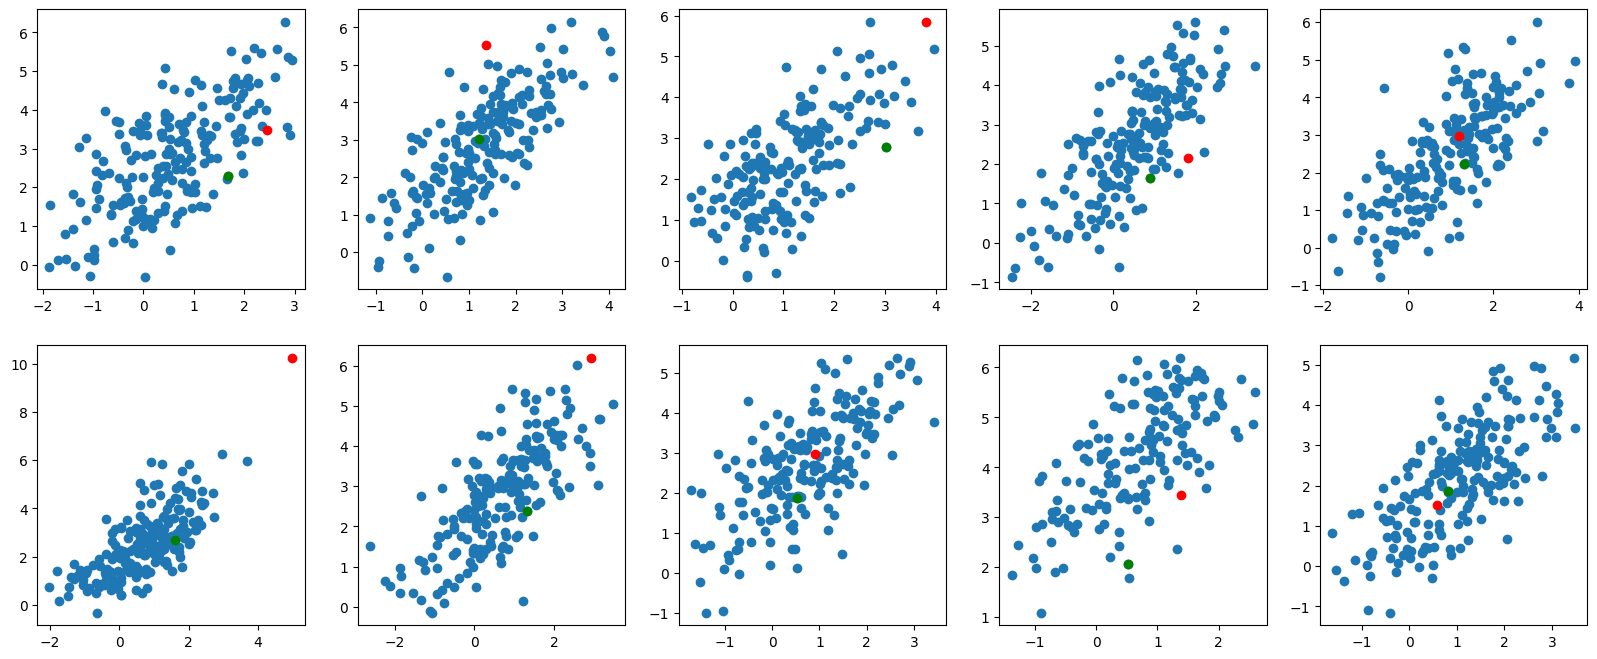

In [439]:
make_10_scatterplots(X_test[:10], score_quantile, cvae, lol, lol.mlp[-1], variance_est, 200, Y_test[:10])